# Assignment 3: Predicting Mapping Penalties with From-Scratch ANN
**Due:** June 5, 2025, 11:59 PM

**Author:** Tony Liang

**Student Number:** 20990204

In this assignment, a feed-forward artificial neural network (ANN) is implemented from scratch to predict the penalty score of a mapping between tasks and employees.

In this notebook we will:
1. Load the 100 mappings dataset  
2. Preprocess & encode into 110-dim vectors  
3. Define the ANN architectures and implement forward, backward, updates by hand  
5. Train via mini-batch SGD over grid of hyperparameters  
6. Produce the eight required comparison plots  
7. Export results for report submission  

## 1. Assignment Imports

In [29]:
try:
  if loaded:
    print("Data loaded!")
except:
  !git clone https://github.com/tonyzrl/ANN_Assignment
loaded = True

Data loaded!


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# For reproducibility
np.random.seed(42)

# Task data: ID, Estimated Time, Difficulty, Deadline, Skill Required
tasks = [{"id": "T1", "estimated_time": 4, "difficulty": 3, "deadline": 8, "skill_required": "A"},
        {"id": "T2", "estimated_time": 6, "difficulty": 5, "deadline": 12, "skill_required": "B"},
        {"id": "T3", "estimated_time": 2, "difficulty": 2, "deadline": 6, "skill_required": "A"},
        {"id": "T4", "estimated_time": 5, "difficulty": 4, "deadline": 10, "skill_required": "C"},
        {"id": "T5", "estimated_time": 3, "difficulty": 1, "deadline": 7, "skill_required": "A"},
        {"id": "T6", "estimated_time": 8, "difficulty": 6, "deadline": 15, "skill_required": "B"},
        {"id": "T7", "estimated_time": 4, "difficulty": 3, "deadline": 9, "skill_required": "C"},
        {"id": "T8", "estimated_time": 7, "difficulty": 5, "deadline": 14, "skill_required": "B"},
        {"id": "T9", "estimated_time": 2, "difficulty": 2, "deadline": 5, "skill_required": "A"},
        {"id": "T10", "estimated_time": 6, "difficulty": 4, "deadline": 11, "skill_required": "C"},]

# Employee data: ID, Available hours, Skill level, Skills
employees = [{"id": "E1", "hours_avail": 10, "skill_level": 4, "skills": ["A", "C"]},
            {"id": "E2", "hours_avail": 12, "skill_level": 6, "skills": ["A", "B", "C"]},
            {"id": "E3", "hours_avail": 8, "skill_level": 3, "skills": ["A"]},
            {"id": "E4", "hours_avail": 15, "skill_level": 7, "skills": ["B", "C"]},
            {"id": "E5", "hours_avail": 9, "skill_level": 5, "skills": ["A", "C"]}]

## 2. Data Loading & Preprocessing

In [31]:
def one_hot_encode(skills):
    """
    One-hot encode a list of skills, e.g. ['A','C'] -> [1,0,1].
    """
    mapping = {'A': 0, 'B': 1, 'C': 2}
    vec = [0, 0, 0]
    for s in skills:
        vec[mapping[s]] = 1
    return vec

def construct_input_vector(mapping_row):
    """
    Construct 110-dim vector from task→employee assignments + penalty.
    """
    input_vector = []
    for idx, emp_id in enumerate(mapping_row[:10], start=1):
        task = next(t for t in tasks if t["id"] == f"T{idx}")
        emp = next(e for e in employees if e["id"] == emp_id)

        # Task features
        input_vector.extend([
            task["estimated_time"],
            task["difficulty"],
            task["deadline"]
        ] + one_hot_encode(task["skill_required"]))

        # Employee features
        input_vector.extend([
            emp["hours_avail"],
            emp["skill_level"],
        ] + one_hot_encode(emp["skills"]))

    return np.array(input_vector)

In [43]:
# Load data
data_df = pd.read_csv('/content/ANN_Assignment/data/task_assignment_data.csv')
data = data_df.values  # (N, 11): 10 assignments + 1 penalty

# Build X, y
assignments, penalties = [], []
for row in data:
    assignments.append(construct_input_vector(row))
    penalties.append(row[-1])

X = np.vstack(assignments)             # (N, 110)
y = np.array(penalties).reshape(-1, 1) # (N,   1)

# Shuffle & split based on proportions
N = X.shape[0]
train_end = int(0.70 * N)
val_end   = train_end + int(0.15 * N)

perm = np.random.permutation(N)
X_sh, y_sh = X[perm], y[perm]

# Slice and transpose for network
X_train = X_sh[:train_end].T
y_train = y_sh[:train_end].T

X_val   = X_sh[train_end:val_end].T
y_val   = y_sh[train_end:val_end].T

X_test  = X_sh[val_end:].T
y_test  = y_sh[val_end:].T

## 3. Model Architecture

### Activation Functions

**ReLU**

The Rectified Linear Unit (ReLU) is a simple, yet highly effective activation function commonly used in Neural Networks. It is defined as:

**\begin{equation}
f(Z) = max(0, Z)
\end{equation}**

Where $Z$ is the input to the function. ReLU sets all negative values of $Z$ to zero, and leaves the positive values unchanged.

The derivative of the ReLU function can be computed as:

**\begin{equation}
f'(Z) = \begin{cases}
0, & \text{if } Z \leq 0 \
1, & \text{if } Z > 0
\end{cases}
\end{equation}**

---

**Sigmoid**

The Sigmoid function is a common activation function used in Neural Networks, particularly for binary classification problems. It is represented by the following formula:

**\begin{equation}
f(Z) = \frac{1}{1+e^{-Z}}
\end{equation}**

Where $Z$ is the input to the function. The Sigmoid function maps any real-valued number to a value between 0 and 1, which can be interpreted as a probability.

The derivative of the Sigmoid function can be computed as:

\begin{equation}
f'(Z) = f(Z)(1-f(Z))
\end{equation}

In [33]:
def sigmoid(Z):
    """
    Implement the Sigmoid function.
    """
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def sigmoid_deriv(dA, cache):
    """
    Implement the backward propagation for a single sigmoid unit.
    """
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

def relu(Z):
    """
    Implement the ReLU function.
    """
    A = np.maximum(0,Z)
    cache = Z
    return A, cache

def relu_deriv(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    """
    Z = cache
    dZ = np.array(dA, copy=True)
    # When z <= 0, dz is equal to 0 as well.
    dZ[Z <= 0] = 0
    return dZ

### Neural Network Class

In [34]:
class NeuralNetwork:
    def __init__(self, layer_dims=[110, 256, 1], learning_rate=1e-3, activation='relu'):
        """
        layer_dims: list of layer sizes, e.g [110,256,1] or [110,128,128,1]
        learning_rate: step size for gradient descent
        activation: 'relu' or 'sigmoid' for hidden layers
        """
        self.layer_dims = layer_dims
        self.learning_rate = learning_rate

        # pick activation & its derivative
        if activation.lower() == 'relu':
            self.activation = relu
            self.activation_deriv = relu_deriv
        else:
            self.activation = sigmoid
            self.activation_deriv = sigmoid_deriv

        # number of layers (excluding input)
        self.L = len(layer_dims) - 1

        # initialise random values for weights and biases
        for l in range(1, self.L + 1):
            n_in  = layer_dims[l-1]
            n_out = layer_dims[l]
            setattr(self, f'W{l}', np.random.randn(n_out, n_in) * 0.01)
            setattr(self, f'b{l}', np.zeros((n_out, 1)))

    def forward(self, X):
        """
        Performs a full forward pass.
        Returns:
          Zl: (1, m) predictions
          caches: list of ((A,W,b), Z) tuples
        """
        caches = []
        A = X

        # hidden layers
        for l in range(1, self.L):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            Z = W @ A + b
            # Cache (A_prev_for_next_layer, W, b) and Z
            caches.append(((A, W, b), Z))
            # Compute activation output
            A, _ = self.activation(Z)

        # output layer (linear)
        Wl = getattr(self, f'W{self.L}')
        bl = getattr(self, f'b{self.L}')
        Zl = Wl @ A + bl

        # Cache (A for output layer, Wl, bl) and Zl
        caches.append(((A, Wl, bl), Zl))
        return Zl, caches

    def back_layer(self, dZ, cache):
        """
        Backprop for a single layer given dZ = dL/dZ_l.
        cache: ((A_prev, W, b), Z)
        Returns dA_prev, dW, db.
        """
        (A_prev, W, b), Z = cache
        m = A_prev.shape[1]
        dW = (1/m) * (dZ @ A_prev.T)
        db = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = W.T @ dZ
        return dA_prev, dW, db

    def backward(self, Y_hat, Y, caches):
        """
        Performs backprop over the whole network.
        Returns a dict of grads {dW1, db1, …, dWL, dbL}.
        """
        grads = {}
        m = Y.shape[1]

        # dZ for MSE loss at output: d/dZ [ (1/m) ∑ (ZL - Y)^2 ] = 2*(ZL - Y)/m
        dZ = 2 * (Y_hat - Y) / m

        # **Output layer** gradients (Layer L)
        cacheL = caches[-1] # This is the cache for the last layer (output)
        dA_prev, dWl, dbl = self.back_layer(dZ, cacheL)
        grads[f'dW{self.L}'] = dWl
        grads[f'db{self.L}'] = dbl

        # **Hidden layers** (L-1 .. 1)
        # dA here is the gradient of the cost with respect to the activation output of layer L-1
        dA = dA_prev
        for l in reversed(range(1, self.L)): # Loop through hidden layers backwards
            # cache for the current layer 'l' from forward pass
            # This cache contains ((A_prev_to_layer_l, W_l, b_l), Z_l)
            cache_l = caches[l-1]

            # Get Z_l from cache
            Z = cache_l[1]

            # Convert dA_l (gradient wrt A_l) to dZ_l (gradient wrt Z_l)
            # A_l is the activation output of layer l.
            # dA was computed as the backprop output from layer l+1,
            # so it's the gradient wrt A_l.
            dZ = self.activation_deriv(dA, Z)

            # Get A_prev_to_layer_l from cache
            A_prev = cache_l[0][0]

            # Backprop through the linear part of layer l
            dA, dW, db = self.back_layer(dZ,((A_prev, cache_l[0][1], cache_l[0][2]), Z))
            grads[f'dW{l}'] = dW
            grads[f'db{l}'] = db
        return grads

    def update_parameters(self, grads):
        """
        Applies gradient descent: W -= lr * dW,  b -= lr * db.
        """
        for l in range(1, self.L+1):
            W = getattr(self, f'W{l}')
            b = getattr(self, f'b{l}')
            dW = grads[f'dW{l}']
            db = grads[f'db{l}']
            setattr(self, f'W{l}', W - self.learning_rate * dW)
            setattr(self, f'b{l}', b - self.learning_rate * db)

    def compute_cost(self, Y_hat, Y):
        """
        Mean Squared Error:
          (1/m) * sum((Y_hat - Y)^2)
        Y_hat, Y both shape (1, m)
        """
        return np.mean((Y_hat - Y)**2)

## 4. Training Loop

In [45]:
def training(layer_dims):
    # Hyperparameter grid
    learning_rates = [0.01, 0.001, 0.0001]
    batch_sizes    = [8, 16, 32]
    activations    = ['sigmoid', 'relu']
    epochs         = 100

    results = []

    # Training Loop
    for lr in learning_rates:
        for batch_size in batch_sizes:
            for activation in activations:
                # Instantiate a fresh model for this combo
                model = NeuralNetwork(layer_dims,
                                      learning_rate=lr,
                                      activation=activation)
                train_losses = []
                val_losses   = []
                epoch_times  = []

                # Epoch loop
                for epoch in range(epochs):
                    t0 = time.time()

                    # Shuffle training set
                    perm = np.random.permutation(X_train.shape[1])
                    X_sh = X_train[:, perm]
                    y_sh = y_train[:, perm]

                    # Mini-batch gradient descent
                    for i in range(0, X_sh.shape[1], batch_size):
                        xb = X_sh[:, i:i+batch_size]
                        yb = y_sh[:, i:i+batch_size]

                        # forward → backward → update
                        y_hat, caches = model.forward(xb)
                        grads = model.backward(y_hat, yb, caches)
                        model.update_parameters(grads)

                    # Record epoch-level train & val loss
                    y_hat_tr, _ = model.forward(X_train)
                    train_losses.append(model.compute_cost(y_hat_tr, y_train))

                    y_hat_val, _ = model.forward(X_val)
                    val_losses.append(model.compute_cost(y_hat_val, y_val))

                    epoch_times.append(time.time() - t0)

                # Final test evaluation
                y_hat_test, _ = model.forward(X_test)
                test_loss = model.compute_cost(y_hat_test, y_test)

                # Store this run’s results
                results.append({
                    'layer_dims':   layer_dims,
                    'learning_rate': lr,
                    'batch_size':   batch_size,
                    'activation':   activation,
                    'train_losses': train_losses,
                    'val_losses':   val_losses,
                    'epoch_times':  epoch_times,
                    'test_loss':    test_loss
                })
    return results

# Defining model parameters and begin training
resultsA = training(modelA=[110, 256, 1])
resultsB = training(modelB=[110, 128, 128, 1])

# Compare test losses:
print("Model A best test loss:", min(r['test_loss'] for r in resultsA))
print("Model B best test loss:", min(r['test_loss'] for r in resultsB))

Model A best test loss: 2.883947687150181
Model B best test loss: 2.7952604995726515


## 5. Evaluation and Plots

### Epoch vs Loss (Train & Val)


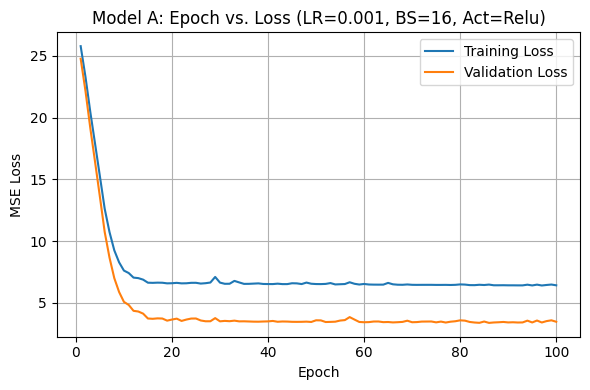

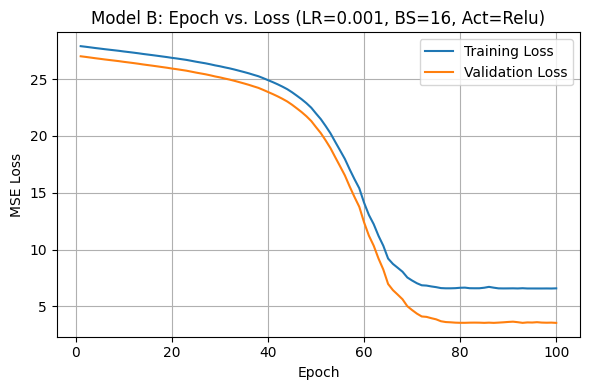

In [36]:
def plot_epoch_vs_loss(runs, model_label, learning_rate=0.001, batch_size=16,
                       activation='relu', out_file=None):
    run = next(r for r in runs
               if r['learning_rate'] == learning_rate
               and r['batch_size']   == batch_size
               and r['activation']   == activation)

    train, val = run['train_losses'], run['val_losses']
    epochs = range(1, len(train) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label='Training Loss')
    plt.plot(epochs, val,   label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.title(f"{model_label}: Epoch vs. Loss "
              f"(LR={learning_rate}, BS={batch_size}, Act={activation.capitalize()})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)

plot_epoch_vs_loss(resultsA, 'Model A', out_file='modelA_Epoch_vs_Loss.png')
plot_epoch_vs_loss(resultsB, 'Model B', out_file='modelB_Epoch_vs_Loss.png')

### Learning Rate vs Loss (Test)

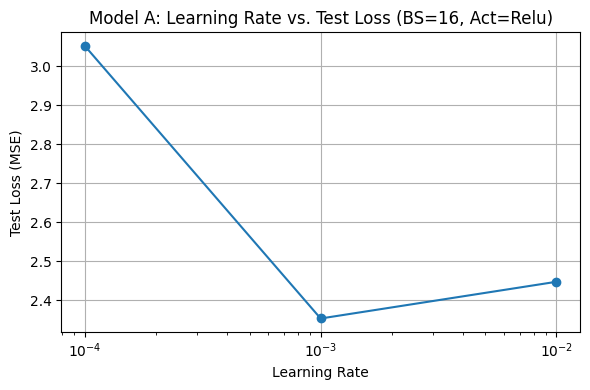

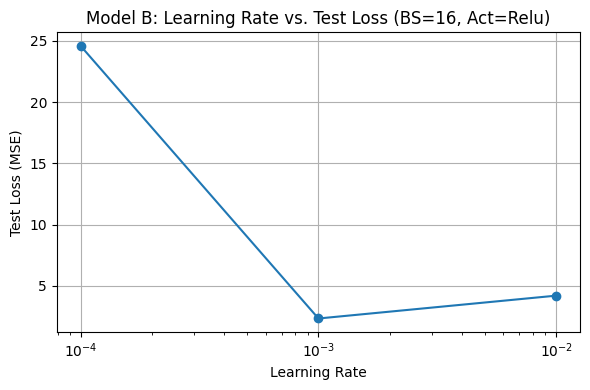

In [37]:
def plot_lr_vs_test_loss(runs, model_label, batch_size=16, activation='relu',
                         out_file=None):
    # collect and sort (lr, loss) pairs
    lr_loss = [
        (r['learning_rate'], r['test_loss'])
        for r in runs
        if r['batch_size'] == batch_size and r['activation'] == activation
    ]
    lrs, losses = zip(*sorted(lr_loss, key=lambda x: x[0]))

    plt.figure(figsize=(6,4))
    plt.plot(lrs, losses, marker='o')
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Test Loss (MSE)')
    plt.title(f"{model_label}: Learning Rate vs. Test Loss "
              f"(BS={batch_size}, Act={activation.capitalize()})")
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)

plot_lr_vs_test_loss(resultsA, 'Model A', out_file='modelA_LR_vs_TestLoss.png')
plot_lr_vs_test_loss(resultsB, 'Model B', out_file='modelB_LR_vs_TestLoss.png')

### Activation Function vs Loss (Train & Val)

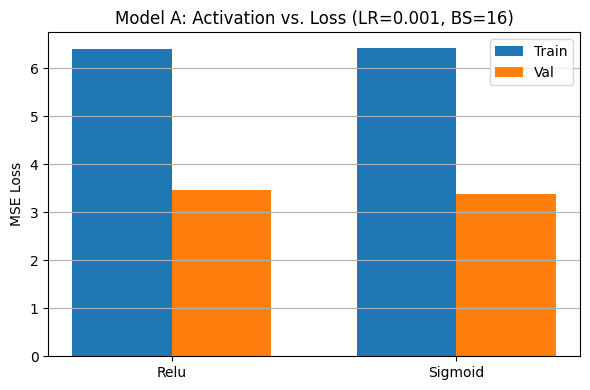

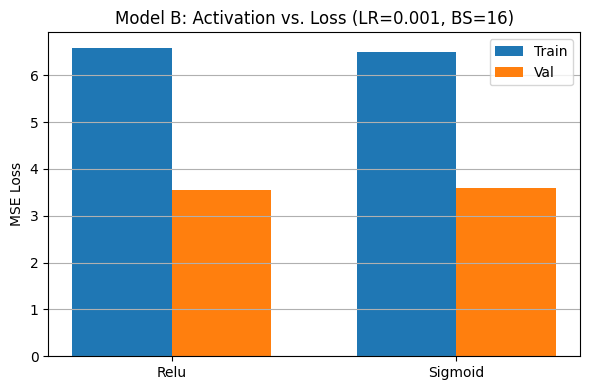

In [38]:
def plot_activation_vs_loss(runs, model_label, learning_rate=0.001, batch_size=16,
                            activations=('relu', 'sigmoid'), out_file=None):
    # collect last‐epoch train & val losses for each activation
    train_losses = []
    val_losses   = []
    for act in activations:
        run = next(r for r in runs
                   if r['activation']    == act
                   and r['learning_rate'] == learning_rate
                   and r['batch_size']    == batch_size)
        train_losses.append(run['train_losses'][-1])
        val_losses.append(  run['val_losses'][-1])

    x = np.arange(len(activations))
    width = 0.35

    plt.figure(figsize=(6,4))
    plt.bar(x - width/2, train_losses, width, label='Train')
    plt.bar(x + width/2, val_losses,   width, label='Val')
    plt.xticks(x, [a.capitalize() for a in activations])
    plt.title(f"{model_label}: Activation vs. Loss "
              f"(LR={learning_rate}, BS={batch_size})")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)

plot_activation_vs_loss(resultsA, 'Model A', out_file='modelA_AF_vs_Loss.png')
plot_activation_vs_loss(resultsB, 'Model B', out_file='modelB_AF_vs_Loss.png')

### Batch Size vs Epoch Time

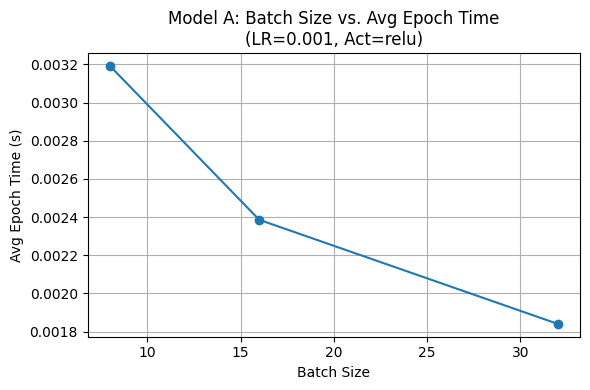

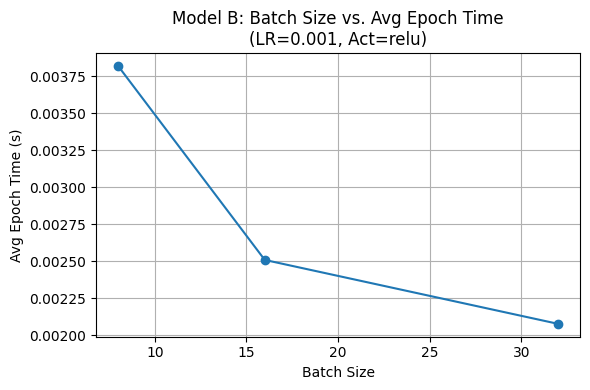

In [39]:
def plot_bs_vs_epoch_time(runs, model_label, learning_rate=0.001, activation='relu',
                          batch_sizes=(8, 16, 32), out_file=None):
    avg_times = []
    for bs in batch_sizes:
        run = next(r for r in runs
                   if r['batch_size']    == bs
                   and r['learning_rate'] == learning_rate
                   and r['activation']    == activation)
        avg_times.append(np.mean(run['epoch_times']))

    plt.figure(figsize=(6,4))
    plt.plot(batch_sizes, avg_times, marker='o')
    plt.xlabel('Batch Size')
    plt.ylabel('Avg Epoch Time (s)')
    plt.title(f"{model_label}: Batch Size vs. Avg Epoch Time\n"
              f"(LR={learning_rate}, Act={activation})")
    plt.grid(True)
    plt.tight_layout()

    if out_file:
        plt.savefig(out_file)

plot_bs_vs_epoch_time(resultsA, 'Model A', out_file='modelA_BS_vs_EpochTime.png')
plot_bs_vs_epoch_time(resultsB, 'Model B', out_file='modelB_BS_vs_EpochTime.png')

## 6. Exporting Plots

In [40]:
from google.colab import files

# Downloading figures locally
files.download('modelA_Epoch_vs_Loss.png')
files.download('modelB_Epoch_vs_Loss.png')

files.download('modelA_LR_vs_TestLoss.png')
files.download('modelB_LR_vs_TestLoss.png')

files.download('modelA_AF_vs_Loss.png')
files.download('modelB_AF_vs_Loss.png')

files.download('modelA_BS_vs_EpochTime.png')
files.download('modelB_BS_vs_EpochTime.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>